In [ ]:
pip --version

: 

In [1]:
import glob
from pathlib import Path
from typing import List, Union

import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.image import resample_img
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

#from evaluate import get_diff_img
import preprocessing as pp_utils
import SimpleITK as sitk
from ipywidgets import interact, VBox, HBox, HTML
import os
import ants

# Utils

In [2]:
def resampling(root_path, adc_path=None, results_dir=None, ncct_path=None):

    results_dir.mkdir(exist_ok=True)
    
    def resample_to_isotropic(nib_image, target_voxel_size=(1.0, 1.0, 1.0), interpolation='linear'):
        """
        Resamplea una imagen NIfTI a resolución isotrópica 1mm³ usando nilearn.
        """
        target_affine = np.diag(list(target_voxel_size) + [1])
        resampled = resample_img(
            nib_image,
            target_affine=target_affine,
            interpolation=interpolation
        )
        return resampled.get_fdata(), resampled.affine, resampled.header

    if adc_path is not None:
        adc_extension = "".join(adc_path.suffixes)
        print("adc_extension:", adc_extension)
        adc_filename = adc_path.name.replace(adc_extension, "")
        print("adc_filename:", adc_filename)

        adc = nib.load(adc_path)
        print("file loaded")

        adc_arr, adc_aff, adc_header = resample_to_isotropic(adc, target_voxel_size=(1.0, 1.0, 1.0), interpolation='linear')
        print("resampled")

        adc_resampled_img = nib.Nifti1Image(adc_arr, adc_aff, adc_header)
        adc_resampled_path = results_dir / f"{adc_filename}_resampled{adc_extension}"
        nib.save(adc_resampled_img, adc_resampled_path)
        print(f"saved: {adc_resampled_path}")
    else:
        adc_resampled_path = None

    if ncct_path is not None:
        ncct_extension = "".join(ncct_path.suffixes)
        ncct_filename = ncct_path.name.replace(ncct_extension, "")  

        ncct = nib.load(ncct_path)
        print("NCCT file loaded")

        ncct_arr, ncct_aff, ncct_header = resample_to_isotropic(ncct, target_voxel_size=(1.0, 1.0, 1.0), interpolation='linear')
        print("resampled")

        ncct_resampled_img = nib.Nifti1Image(ncct_arr, ncct_aff, ncct_header)
        ncct_resampled_path = results_dir / f"{ncct_filename}_resampled{ncct_extension}"
        nib.save(ncct_resampled_img, ncct_resampled_path)
        print(f"saved: {ncct_resampled_path}")
    else:
        ncct_resampled_path = None

    if adc_path is None and ncct_path is None:
        print("No ADC or NCCT path was given")
        return None, None, None
    elif adc_path is None:
        return None, ncct_resampled_path
    elif ncct_path is None:
        return adc_resampled_path, None

    return adc_resampled_path, ncct_resampled_path

In [3]:
def skull_stripping(adc_resampled_path, results_dir):
    print("inside skullstripping function")
    adc_output_img_path, adc_output_bm_path = pp_utils.synthstrip_wrapper(input_img_path= adc_resampled_path,
                                                                          results_dir= Path(results_dir),
                                                                          write_brain_mask= True,
                                                                          verbose=True,)
    print("saved on: ", results_dir)
    return adc_output_img_path, adc_output_bm_path

In [4]:
def ncct_mprage(ncct_resampled_path, results_dir):
    if ncct_resampled_path is not None:
        try:
            ncct_output_img_path = pp_utils.synthsr_wrapper(input_img_path=ncct_resampled_path, 
                                                            results_dir= Path(results_dir), 
                                                            is_input_ct=True, verbose=True)
        except:
            None
    else:
        ncct_output_img_path = None
        
    return ncct_output_img_path


def mprage_skull_stripping(ncct_output_img_path, results_dir):
    if ncct_output_img_path is not None:
        try:
            ncct_output_img_path, ncct_output_bm_path = pp_utils.synthstrip_wrapper(Path(ncct_output_img_path), 
                                                                                    results_dir=Path(results_dir),
                                                                                    write_brain_mask=True, verbose=True)
        except:
            None
    else:
        ncct_output_img_path, ncct_output_bm_path = None, None
        
    return ncct_output_img_path, ncct_output_bm_path

In [5]:
def ants_rigid_registration(template_path, mri_path, results_dir, modality):
    #perform the rigid registration from the subject to the template
    
    print("RIGID REGISTRATION: from subject to template:")
    print("starting registration")
    print("reading the template")
    template_image = ants.image_read(template_path) 
    print("reading the mri")
    mri_image = ants.image_read(mri_path)     
    
    registration = ants.registration(fixed=template_image, moving=mri_image,
                                        type_of_transform='Rigid') 
    
    # Apply the transformation to the moving image
    print("applying the transformation")
    warped_image = ants.apply_transforms(fixed=template_image, moving=mri_image,
                                        transformlist=registration['fwdtransforms'])
    print("RIGID transformation applied") 
    
    if modality == "mri":
        print("modality is mri")
        mri_file_name = mri_path.split("/")[-1]
        prefix = mri_file_name.split(".")[0]
        output_rigid_path = os.path.join(results_dir, prefix + '_rigid_registered.nii.gz')
        
    else:
        mri_file_name = mri_path.split("/")[-1]
        print("mri_file_name", mri_file_name)
        current_file_name = mri_file_name.split(".")[0]
        final_name = current_file_name + "_rigid_registered.nii.gz"
        output_rigid_path = os.path.join(results_dir, final_name)
        
    ants.image_write(warped_image, output_rigid_path)
    print("saved at", output_rigid_path)
    return output_rigid_path

In [6]:
def ants_elastic_registration(template_path, output_rigid_path, saved_files):
    #perform the elastic registration from the template to the subject
    print("ELASTIC REGISTRATION: from template to subject:")
    print("starting registration")
    print("reading the template")
    template_image = ants.image_read(template_path) 
    print("reading the mri")
    rigid_image = ants.image_read(output_rigid_path)     
    
    registration = ants.registration(fixed=rigid_image, moving=template_image,
                                        type_of_transform='SyN') 
    
    # Apply the transformation to the moving image
    print("applying the transformation")
    warped_image = ants.apply_transforms(fixed=rigid_image, moving=template_image,
                                        transformlist=registration['fwdtransforms'])
    print("ELASTIC transformation applied") 
    
    mri_file_name = output_rigid_path.split("/")[-1]
    prefix = mri_file_name.split(".")[0]
    output_elastic_path = os.path.join(saved_files, prefix + '_elastic_registered.nii.gz')
        
    ants.image_write(warped_image, output_elastic_path)
    print("saved at", output_elastic_path)
    return output_elastic_path
    

In [7]:
def ants_warp(atlas_path, output_elastic_path, to_save):
    
    print("==== **SUBCORTICAL WARP** ====")
    #here the subcortical atlas is warped to the elastic warped image
    print("reading the atlas")
    atlas_image = ants.image_read(atlas_path)
    print("atlas loaded")
    print("loading the elastic warped image")
    elastic_warped_image = ants.image_read(output_elastic_path)

    print("defining the registration")                
    registration = ants.registration(fixed=elastic_warped_image, moving=atlas_image,
                                        type_of_transform='SyN')

    print("registration defined")

    print("applying the transformation")
    warped_image = ants.apply_transforms(fixed=elastic_warped_image, moving=atlas_image,
                                        transformlist=registration['fwdtransforms'])
    print("TRANSFORMATION applied")   
    
    mri_file_name = output_elastic_path.split("/")[-1]
    prefix = mri_file_name.split(".")[0]
    output_final_registered_path = os.path.join(to_save, prefix + '_final.nii.gz')
    
    ants.image_write(warped_image, output_final_registered_path)
    print("saved at", output_final_registered_path)
    
    return output_final_registered_path

In [8]:
def field_bias_correction(raw_img_path, results_dir, modality):
    
    #reading the mri image in nii or ni.gz format
    print("reading the raw image")
    raw_img_sitk = sitk.ReadImage(raw_img_path, sitk.sitkFloat32) 
    #getting the array
    raw_img_sitk_arr = sitk.GetArrayFromImage(raw_img_sitk) #3
    #==== creating the brain mask ==== 
    #rescale intensity values
    print("rescaling the intesities 0-255")
    transformed = sitk.RescaleIntensity(raw_img_sitk, 0, 255) #1
    #getting the brain mask
    print("getting the brain mask")
    transformed = sitk.LiThreshold(transformed,0,1) #2
    head_mask = transformed
    
    #=========== applying the bias field correction ===========
    #factor de encogemiento de la img original (menos costo computacional)
    shrinkFactor = 4 
    inputImage = raw_img_sitk

    #applying the shrink factor
    print("applying the shrink factor")
    inputImage = sitk.Shrink( raw_img_sitk, [ shrinkFactor ] * inputImage.GetDimension() )
    #the same factor to the brain mask
    maskImage = sitk.Shrink( head_mask, [ shrinkFactor ] * inputImage.GetDimension() ) #3

    #creating the biasFieldCorrector object
    bias_corrector = sitk.N4BiasFieldCorrectionImageFilter()

    #applying the bias correction to the shrinked versions
    print("applying the bias correction to the shrinked versions")
    corrected = bias_corrector.Execute(inputImage, maskImage)
    
    #======= applying the bias field correction to the original image dimensions =======
    # logaritmic bias field
    log_bias_field = bias_corrector.GetLogBiasFieldAsImage(raw_img_sitk) 
    #escale in the original image version
    print("escale in the original image version")
    corrected_image_full_resolution = raw_img_sitk / sitk.Exp( log_bias_field )
    
    #saving the results
    # Save the output
    print("saving the results")
    to_save = results_dir
    if modality == "mri":
        print("raw_img_path: ", raw_img_path)
        mri_file_name = raw_img_path.split("/")[-1]
        print("mri_file_name", mri_file_name)
        prefix = mri_file_name.split("-")[0]
        print("prefix", prefix)
        output_warped_path = os.path.join(to_save, prefix + '_resampled_brain_extracted_bias_corrected.nii.gz')
        print("output_warped_path", output_warped_path)
    else:
        mri_file_name = raw_img_path.split("/")[-1]
        print("mri_file_name", mri_file_name)
        current_file_name = mri_file_name.split(".")[0]
        final_name = current_file_name + "_bias_corrected.nii.gz"
        output_warped_path = os.path.join(to_save, final_name)
    
    sitk.WriteImage(corrected_image_full_resolution, output_warped_path)
    
    print("corrected image saved in: ", output_warped_path)
    
    return output_warped_path


# Main

## **Preprocessing MRI and SPECT (only the resampling step)**
* For Control and Parkinson populations

In [9]:
#getting all the related cases
root_path = "/home/Data/Datasets/Parkinson/radiological/PPMI/spect-mri/filtered/FinalExtension/data/classifier"
split = "train"
group = "parkinson"
modality = "spect"
current_root_path = root_path + "/" + group + "_" + split + "/" + modality + "_png"
cases = sorted(os.listdir(current_root_path))
print(len(cases))

FileNotFoundError: [Errno 2] No such file or directory: '/home/Data/Datasets/Parkinson/radiological/PPMI/spect-mri/filtered/FinalExtension/data/classifier/parkinson_train/spect_png'

* For SWEDD and Prodromal

In [9]:
group = "prodromal"
modality = "mri"

root_path = "../../../../../Datasets/Parkinson/radiological/PPMI/spect-mri/filtered/"
current_root_path = os.path.join(root_path, group, modality)
cases = sorted(os.listdir(current_root_path))
print(len(cases))

FileNotFoundError: [Errno 2] No such file or directory: '../../../../../Datasets/Parkinson/radiological/PPMI/spect-mri/filtered/prodromal/mri'

## **All preprocessing steps at the same time**

**Resampling and skullstripping steps**

In [20]:
group = "pd"
modality = "spect"
root_path = "/home/Data/franklin_pupils/angel/PPMI"
current_root_path = os.path.join(root_path)
cases = sorted(os.listdir(current_root_path))
print(cases)

['100001', '100002', '100004', '100890', '100956', '100972', '101025', '101039', '101187', '101195', '101480', '101516', '101555', '101556', '101680', '101747', '102003', '102293', '102305', '102308', '102366', '102381', '102428', '102447', '102475', '103161', '103183', '103467', '103542', '106126', '106127', '106864', '108909', '110220', '110535', '110686', '110919', '111099', '111278', '112926', '113043', '113050', '113355', '113369', '113447', '114137', '115448', '115698', '116230', '116231', '116337', '118726', '119428', '119797', '120376', '120545', '121619', '121621', '121830', '124793', '126812', '128335', '129031', '130028', '130074', '130190', '130468', '130828', '135579', '135705', '136600', '137499', '138022', '139138', '140451', '141692', '141710', '141714', '141893', '142086', '142087', '142879', '143192', '144147', '144163', '144254', '146875', '147294', '147341', '147401', '147406', '147650', '149005', '149006', '149120', '149716', '149807', '149808', '149945', '150505',

In [24]:

# --- FUNCIONES AUXILIARES ---
def resampling(case_dir, adc_path, results_dir, ncct_path=None):
    """
    Ejemplo de función que carga, re-muestrea (dummy aquí) y guarda.
    Devuelve la ruta del archivo guardado.
    """
    try:
        img = nib.load(str(adc_path))
        data = img.get_fdata()
        affine = img.affine

        # Ejemplo de operación de "resample" (sin cambios)
        resampled_data = data  # Aquí va tu lógica real

        # Nombre de salida
        name = adc_path.name
        if name.endswith(".nii.gz"):
            base = name[:-7]  # elimina ".nii.gz"
        elif name.endswith(".nii"):
            base = name[:-4]  # elimina ".nii"
        else:
            base = adc_path.stem

        filename = base + "_resampled.nii.gz"
        out_path = results_dir / filename

        nib.save(nib.Nifti1Image(resampled_data, affine), str(out_path))
        print(f"✅ Archivo resampleado guardado en: {out_path}")

        return out_path, None
    except Exception as e:
        raise RuntimeError(f"Error en resampling: {e}")

def skull_stripping(adc_resampled_path, results_dir):
    """
    Ejemplo de función de skull stripping (aquí simplemente copia el archivo).
    """
    try:
        img = nib.load(str(adc_resampled_path))
        data = img.get_fdata()
        affine = img.affine

        # Aquí podrías aplicar un método real de skull stripping
        brain_masked = data  # Placeholder

        out_path = results_dir / (adc_resampled_path.stem + "_brain_extracted.nii")
        nib.save(nib.Nifti1Image(brain_masked, affine), str(out_path))
        print(f"✅ Archivo brain extracted guardado en: {out_path}")

        return out_path
    except Exception as e:
        raise RuntimeError(f"Error en skull stripping: {e}")

# --- CONFIGURACIÓN ---
split = globals().get("split", "unknown")
modality = "spect"
current_root_path = Path("/home/Data/franklin_pupils/angel/PPMI")
error_log_path = "errores_log.txt"

# Lista de casos (subcarpetas dentro de pd)
cases = [c for c in os.listdir(current_root_path) if os.path.isdir(current_root_path / c)]

for case in cases:
    print(f"\n🔹 case: {case}")
    case_dir = current_root_path / case

    try:
        # Buscar archivos .nii o .nii.gz dentro del caso
        nii_files = [f for f in os.listdir(case_dir) if f.endswith((".nii", ".nii.gz"))]
        if not nii_files:
            print(f"⚠️ No se encontraron archivos NIfTI en {case_dir}")
            continue

        # Tomar el primero (o podrías filtrar por fecha si lo deseas)
        mri_file = nii_files[0]
        mri_path = case_dir / mri_file
        print(f"mri_path: {mri_path}")

        # Crear carpeta preprocessed
        results_dir = case_dir / "preprocessed"
        results_dir.mkdir(parents=True, exist_ok=True)
        print(f"results_dir: {results_dir}")

        # Paso 1: Resampling
        try:
            adc_resampled_path, _ = resampling(case_dir, adc_path=mri_path, results_dir=results_dir)
        except Exception as e:
            with open(error_log_path, "a") as f:
                f.write(f"[Resampling Error] {case} | {e}\n")
            continue

        # Paso 2: Skull stripping (solo si no es SPECT)
        if modality != "spect":
            try:
                skull_stripping(adc_resampled_path, results_dir)
            except Exception as e:
                with open(error_log_path, "a") as f:
                    f.write(f"[SkullStripping Error] {case} | {e}\n")
                continue

    except Exception as e:
        with open(error_log_path, "a") as f:
            f.write(f"[General Error] {case} | {e}\n")
        continue



🔹 case: 110220
mri_path: /home/Data/franklin_pupils/angel/PPMI/110220/110220_Anon_20230224103000_1.nii.gz
results_dir: /home/Data/franklin_pupils/angel/PPMI/110220/preprocessed
✅ Archivo resampleado guardado en: /home/Data/franklin_pupils/angel/PPMI/110220/preprocessed/110220_Anon_20230224103000_1_resampled.nii.gz

🔹 case: 3133
mri_path: /home/Data/franklin_pupils/angel/PPMI/3133/3133_Reconstructed_DaTSCAN_20130307130030_1.nii.gz
results_dir: /home/Data/franklin_pupils/angel/PPMI/3133/preprocessed
✅ Archivo resampleado guardado en: /home/Data/franklin_pupils/angel/PPMI/3133/preprocessed/3133_Reconstructed_DaTSCAN_20130307130030_1_resampled.nii.gz

🔹 case: 3479
mri_path: /home/Data/franklin_pupils/angel/PPMI/3479/3479_Reconstructed_DaTSCAN_20121211152404_1000.nii.gz
results_dir: /home/Data/franklin_pupils/angel/PPMI/3479/preprocessed
✅ Archivo resampleado guardado en: /home/Data/franklin_pupils/angel/PPMI/3479/preprocessed/3479_Reconstructed_DaTSCAN_20121211152404_1000_resampled.nii.gz

**Bias field correction and Registration process**

In [11]:

modality="spect"
print(modality)

spect


In [12]:
print(current_root_path)

/home/Data/franklin_pupils/angel/PPMI


In [25]:
cases= ['3411', '3414', '3417', '3424', '3431', '3435', '3438', '3445', '3448', '3450', '3452', '3453', '3455', '3457', '3458', '3460', '3461', '3464', '3466', '3468', '3478', '3479', '3480', '3481', '3503', '3515', '3517', '3518', '3521', '3522', '3523', '3524', '3525', '3526', '3527', '3530', '3536', '3541', '3543', '3544', '3576', '3600', '3604', '3606', '3607', '3611', '3612', '3613', '3614', '3615', '3619', '3620', '3624', '3625', '3627', '3629', '3635', '3636', '3637', '3638', '3639', '3651', '3654', '3656', '3658', '3662', '3664', '3668', '3700', '3707', '3710', '3711', '3754', '3785', '3792', '3793', '3794', '3796', '3856', '3901', '3903', '3907', '3908', '3917', '3950', '3952', '3955', '3959', '3960', '3965', '3966', '3967', '3968', '3969', '3971', '3972', '4003', '4007', '4008', '4009', '4014', '4017', '40533', '40538', '40543', '40553', '4057', '4058', '40603', '40607', '40608', '4063', '40692', '4070', '40702', '40709', '40713', '4072', '40731', '40733', '4074', '40744', '40756', '4076', '4079', '4090', '4091', '4095', '4100', '41039', '4104', '4105', '4107', '4116', '4118', '4125', '4137', '4140', '41400', '41401', '41420', '41521', '41522', '41985', '42014', '42407', '42448', '42710', '42888', '43046', '5001', '5003', '5005', '5007', '5008', '50086', '5011', '50175', '50860', '51518', '51844', '54161', '55124', '56744', '56761', '57798', '57880', '57887', '58510', '58550', '59121', '59398', '70818', '72784', '73115', '73935', '74034', '74067', '75484']

In [ ]:
base_path = "/home/Data/franklin_pupils/angel/PPMI"
atlas_path = '/home/Data/franklin_pupils/angel/all_t1/HarvardOxford-sub-maxprob-thr25-1mm.nii.gz'
template_path = '/home/Data/franklin_pupils/angel/all_t1/MNI152_T1_1mm.nii.gz'                              

# cases = [3108, 3366, 3380, 4034]
for case in cases:
    print("======= case: =======", case)
    saved_files = os.path.join(current_root_path, case, "preprocessed")
    files = os.listdir(saved_files)
    # if any(file.endswith("rigid_registered.nii.gz") for file in files):
    #     print(f"Ya existe archivo registrado rígidamente para el caso {case}, se omite.")
    #     continue
    if modality == "mri":
        nii_files = [file for file in files if file.endswith("resampled_brain_extracted.nii")]          
    else:
        nii_files = [file for file in files if file.endswith("resampled.nii.gz")]         
    
    current_register_file = nii_files[0]
    mri_path = saved_files + "/" + current_register_file
    print("mri_path", mri_path)
    #making the bias field correction step
    new_mri_path = field_bias_correction(mri_path, saved_files, modality)
    print("bias field correction done")
    
    #making the rigid registration to reference template    
    output_rigid_path = ants_rigid_registration(template_path, new_mri_path, saved_files, modality)
    #making the elastic registration from template to reference case
    print("making the elastic registration from template to reference case")
    output_elastic_path = ants_elastic_registration(template_path, output_rigid_path, saved_files)
    #applying the warp to the subcortical atlas
    ants_warp(atlas_path, output_elastic_path, saved_files)
    print("registration done")
print("done")

======= case: ======= 3411
mri_path /home/Data/franklin_pupils/angel/PPMI/3411/preprocessed/3411_Reconstructed_DaTSCAN_20101104144001_7_resampled.nii.gz
reading the raw image


rescaling the intesities 0-255
getting the brain mask
applying the shrink factor
applying the bias correction to the shrinked versions
escale in the original image version
saving the results
mri_file_name 3411_Reconstructed_DaTSCAN_20101104144001_7_resampled.nii.gz
corrected image saved in:  /home/Data/franklin_pupils/angel/PPMI/3411/preprocessed/3411_Reconstructed_DaTSCAN_20101104144001_7_resampled_bias_corrected.nii.gz
bias field correction done
RIGID REGISTRATION: from subject to template:
starting registration
reading the template
reading the mri
applying the transformation
RIGID transformation applied
mri_file_name 3411_Reconstructed_DaTSCAN_20101104144001_7_resampled_bias_corrected.nii.gz
saved at /home/Data/franklin_pupils/angel/PPMI/3411/preprocessed/3411_Reconstructed_DaTSCAN_20101104144001_7_resampled_bias_corrected_rigid_registered.nii.gz
making the elastic registration from template to reference case
ELASTIC REGISTRATION: from template to subject:
starting registration
read

In [19]:
new_mri_path = "/home/Data/franklin_pupils/angel/PPMI/120376/preprocessed/120376_Anon_20211215162021_1_resampled_bias_corrected.nii.gz"
print("bias field correction done")

#making the rigid registration to reference template    
output_rigid_path = ants_rigid_registration(template_path, new_mri_path, saved_files, modality)
#making the elastic registration from template to reference case
print("making the elastic registration from template to reference case")
output_elastic_path = ants_elastic_registration(template_path, output_rigid_path, saved_files)
#applying the warp to the subcortical atlas
ants_warp(atlas_path, output_elastic_path, saved_files)
print("registration done")

bias field correction done
RIGID REGISTRATION: from subject to template:
starting registration
reading the template
reading the mri
applying the transformation
RIGID transformation applied
mri_file_name 120376_Anon_20211215162021_1_resampled_bias_corrected.nii.gz
saved at /home/Data/franklin_pupils/angel/PPMI/120376/preprocessed/120376_Anon_20211215162021_1_resampled_bias_corrected_rigid_registered.nii.gz
making the elastic registration from template to reference case
ELASTIC REGISTRATION: from template to subject:
starting registration
reading the template
reading the mri
applying the transformation
ELASTIC transformation applied
saved at /home/Data/franklin_pupils/angel/PPMI/120376/preprocessed/120376_Anon_20211215162021_1_resampled_bias_corrected_rigid_registered_elastic_registered.nii.gz
==== **SUBCORTICAL WARP** ====
reading the atlas
atlas loaded
loading the elastic warped image
defining the registration
registration defined
applying the transformation
TRANSFORMATION applied
save

## **Each preprocessing step individually**

**Skullstripping**

In [ ]:
for case in cases:
    print("case: ", case)
    if modality == "mri":
        results_dir = Path(current_root_path + "/" + case + "/preprocessed/skull_biasFC/")
        results_dir.mkdir(exist_ok=True)
        print("results_dir: ", results_dir)
        files = os.listdir(os.path.join(current_root_path, case))
        print("files: ", files)
        raw_nii_file = [file for file in files if file.endswith(".nii")]  
        mri_file = raw_nii_file[0]
        mri_path = Path(os.path.join(current_root_path, case, mri_file))
        print("making skull stripping")
        adc_output_img_path, adc_output_bm_path = skull_stripping(mri_path, results_dir)
        
print("done!")



**Bias field correction**

In [ ]:
current_root_path

In [ ]:
for case in cases[:2]:
    print("case: ", case)
    if modality == "mri":
        results_dir = Path(current_root_path + "/" + case + "/preprocessed/skull_biasFC/")
        results_dir.mkdir(exist_ok=True)
        print("results_dir: ", results_dir)
        print(os.path.join(current_root_path, case, "/skull_biasFC/"))
        files = os.listdir(results_dir)
        print("files: ", files)
        raw_nii_file = [file for file in files if file.endswith("brain_extracted.nii")]  
        print("raw_nii_file: ", raw_nii_file)
        mri_file = raw_nii_file[0]
        mri_path = os.path.join(current_root_path, case, "preprocessed/skull_biasFC/", mri_file)
        print("mri_path: ", mri_path)
        #making the bias field correction step
        new_mri_path = field_bias_correction(mri_path, results_dir, modality)
        print("bias field correction done")
    
    else:
        print("for SPECT modality the bias field correction is not needed")
        
    
print("done!")

# **Checking the dimensions of registered cases**

In [ ]:
split = "train"
group = "parkinson"
modality = "spect"
general_path = "../../../../../Datasets/Parkinson/radiological/PPMI/spect-mri/filtered/"
current_path = general_path + split + "/" + group + "/" + modality
cases = sorted(os.listdir(os.path.join(current_path)))

#dimensiones de referencia
ref_path = "../../../../../Datasets/Parkinson/radiological/PPMI/spect-mri/filtered/test/control/spect/3104/preprocessed/PPMI_3104_NM_Reconstructed_DaTSCAN_Br_20121011134355542_1_S117556_spect_resampled_bias_corrected_rigid_registered_elastic_registered_final.nii.gz"
sitk_image = sitk.ReadImage(ref_path)
#convert to numpy array
img = sitk.GetArrayFromImage(sitk_image)
ref_w, ref_h, ref_d = img.shape

cases = [3107, 3134, 3307, 3360, 3364, 3564, 3760, 3771, 3826, 3830, 3863, 4001, 4005, 4019, 4035]
cases = [str(case) for case in cases]

for case in cases:
    print("====== case ======", case)
    preprocessed_path = os.path.join(current_path, case, "preprocessed")
    saved_files = os.listdir(preprocessed_path)
    nii_files = [file for file in saved_files if file.endswith("registered_final.nii.gz")]
    #for the atlas elastic registered
    final_path = preprocessed_path + "/" + nii_files[0]
    #for the case rigid registered
    nii_files = [file for file in saved_files if file.endswith("rigid_registered.nii.gz")]
    rigid_path = preprocessed_path + "/" + nii_files[0]
    
    #atlas info
    sitk_image = sitk.ReadImage(final_path)
    #convert to numpy array
    img = sitk.GetArrayFromImage(sitk_image)
    w, h, d = img.shape
    if w != ref_w or h != ref_h or d != ref_d:
        print("ERROR IN ATLAS in case: ", case)
        print("w: ", w, "h: ", h, "d: ", d)
        print("ref_w: ", ref_w, "ref_h: ", ref_h, "ref_d: ", ref_d)
        
    #case info
    sitk_image = sitk.ReadImage(rigid_path)
    #convert to numpy array
    img = sitk.GetArrayFromImage(sitk_image)
    w, h, d = img.shape
    if w != ref_w or h != ref_h or d != ref_d:
        print("ERROR IN CASE in case: ", case)
        print("w: ", w, "h: ", h, "d: ", d)
        print("ref_w: ", ref_w, "ref_h: ", ref_h, "ref_d: ", ref_d)
    
print("done")

**Until here**

**Note:** The cell below if for address singular cases where some preprocessing steps were failed

In [ ]:
#single cases
#rigid registration
root_path = "../../../../../../Datasets/Parkinson/radiological/PPMI/spect-mri/filtered/train/control/mri/3355/preprocessed/"
mri_file = os.path.join(root_path, "PPMI_3355_MR_T1_resampled_brain_extracted_bias_corrected.nii.gz")

base_path = "../../../../../../Datasets/Parkinson/radiological/PPMI/"
atlas_path = base_path + 'atlases/fsl/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr25-1mm.nii.gz'
template_path = base_path + "templates/MNI152_T1_1mm_brain.nii.gz"
modality = "mri"

output_rigid_path = ants_rigid_registration(template_path, mri_file, root_path, modality)
print("output_rigid_path", output_rigid_path)
print("making the elastic registration from template to reference case")
output_elastic_path = ants_elastic_registration(template_path, output_rigid_path, root_path)
print("output_elastic_path", output_elastic_path)
#applying the warp to the subcortical atlas
ants_warp(atlas_path, output_elastic_path, root_path)
print("registration done")

In [ ]:
#bias field corection
root_path = "../../../../../../Datasets/Parkinson/radiological/PPMI/spect-mri/filtered/test/control/mri/3104/"
mri_file = os.path.join(root_path, "preprocessed/PPMI_3104_MR_T1-anatomical_Br_20120904141724121_S103322_I330120_resampled_brain_extracted.nii")
results_dir = "../../../../../../Datasets/Parkinson/radiological/PPMI/spect-mri/filtered/test/control/mri/3104/preprocessed"
modality="mri"
field_bias_correction(mri_file, results_dir, modality=modality)

**Until here**

**Checking the results**

In [11]:
def get_nii_info(path):
  #load in sitk format
  sitk_image = sitk.ReadImage(path)
  #convert to numpy array
  img = sitk.GetArrayFromImage(sitk_image)

  img_shape = sitk_image.GetSize()
  #some info about the image
  print("some image information from nii format: \n")
  print("original spacing: ", sitk_image.GetSpacing())#voxel size
  print("original size: ", img_shape)#image size
  print("image direction: ", sitk_image.GetDirection())#image direction
  print("image origin: ", sitk_image.GetOrigin())#image origin
  print("image pixel type: ", sitk_image.GetPixelIDTypeAsString())#image pixel type
  print("pixel id value type: ", sitk_image.GetPixelIDValue())#image pixel id value
  print("from numpy --> study dimensions: ", img.shape)
  print("min pixel value: {}, max pixel value: {}".format(img.min(), img.max()))
  
  print("intensity in one slice: \n")
  id_indx = 143
  img_slice = img[:,:,id_indx]
  print("min and max pixel value in slice {}: {}, {}".format(id_indx, img_slice.min(), img_slice.max()))

  return img

In [ ]:
#base_path = "../../../../../Datasets/Parkinson/radiological/PPMI/spect-mri/filtered"
final_path = "/home/franklin_pupils/franklin_pupils/angel/all_t1/control/3104/preprocessed/PPMI_3104_MR_T1_resampled_brain_extracted_bias_corrected_rigid_registered.nii.gz"
#final_reg_path = base_path + "test/control/spect/3104/preprocessed/PPMI_3104_NM_Reconstructed_DaTSCAN_Br_20121011134355542_1_S117556_spect_resampled_bias_corrected_rigid_registered_elastic_registered_final.nii.gz"
get_nii_info(final_path)

In [ ]:
base_path = "../../../../../../Datasets/Parkinson/radiological/PPMI/spect-mri/filtered"
path_generated = base_path + "/train/control/mri/3355/preprocessed/PPMI_3355_MR_T1_resampled_brain_extracted_bias_corrected_rigid_registered.nii.gz"
#get_nii_info(path_generated)
get_nii_info("/home/Data/Datasets/Parkinson/radiological/PPMI/spect-mri/filtered/test/parkinson/spect/3108/preprocessed/PPMI_3108_NM_Reconstructed_DaTSCAN_Br_20160421160403255_1_S413725_3108_spect_resampled_bias_corrected_rigid_registered_elastic_registered_final.nii.gz")

# Oxford Brain Atlas
Getting the reference atlas

In [12]:
from nilearn import datasets
from nilearn import image as nimg
from nilearn import plotting as nplot
import os

[fetch_atlas_harvard_oxford] Dataset found in /home/franklin_pupils/franklin_pupils/angel/all_t1/fsl

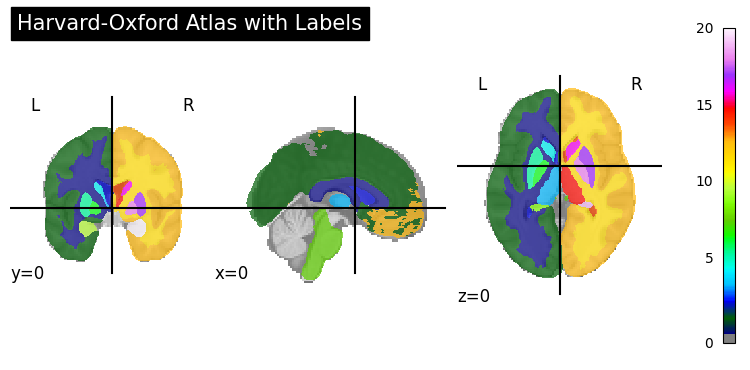

1: Background
2: Left Cerebral White Matter
3: Left Cerebral Cortex
4: Left Lateral Ventricle
5: Left Thalamus
6: Left Caudate
7: Left Putamen
8: Left Pallidum
9: Brain-Stem
10: Left Hippocampus
11: Left Amygdala
12: Left Accumbens
13: Right Cerebral White Matter
14: Right Cerebral Cortex
15: Right Lateral Ventricle
16: Right Thalamus
17: Right Caudate
18: Right Putamen
19: Right Pallidum
20: Right Hippocampus
21: Right Amygdala
22: Right Accumbens


In [13]:
parcel_dir = '/home/franklin_pupils/franklin_pupils/angel/all_t1' 

# Download the Harvard-Oxford atlas
harvard_oxford = datasets.fetch_atlas_harvard_oxford(atlas_name='sub-maxprob-thr25-1mm', data_dir=parcel_dir)

# Access the labels and atlas image
labels = harvard_oxford['labels']
atlas_img = harvard_oxford['maps']

# Display the atlas with labels
nplot.plot_roi(atlas_img, title='Harvard-Oxford Atlas with Labels', display_mode='ortho', cut_coords=(0, 0, 0), colorbar=True)
nplot.show()

# Print the labels
for label_id, label_name in enumerate(labels):
    print(f"{label_id + 1}: {label_name}")

In [2]:
prb_ant="E:/bivl²ab/unificado/parkinson/3102/preprocessed/PPMI_3102_MR_T1-anatomical_Br_20140123143920185_S193426_I406748_resampled_brain_extracted_registered.nii"
nimg.load_img(prb_ant)

### Selecting particular ROI

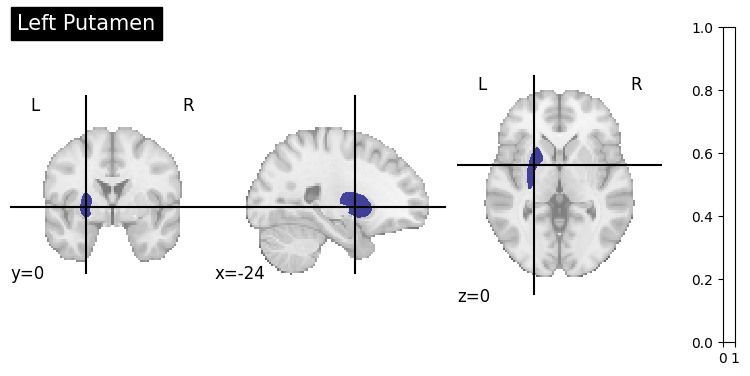

In [14]:
# Make a mask for ROI 7
roi = 6
mask1_nii = nib.load('/home/Data/franklin_pupils/angel/all_t1/HarvardOxford-sub-maxprob-thr25-1mm.nii.gz')
roi_mask_14 = nimg.math_img('a == ' + str(roi), a=atlas_img)  

atlas_img = harvard_oxford['maps']

# Visualize ROI
nplot.plot_roi(roi_mask_14, title=labels[roi])

### Measuring the ROI volume

In [10]:
def calculate_roi_volume(nifti_file_path, roi_label):
    # Load the NIfTI file
    img = nib.load(nifti_file_path)
    data = img.get_fdata()

    # Extract the voxel dimensions
    voxel_dimensions = np.prod(img.header.get_zooms())

    # Calculate the volume of the ROI
    roi_volume = np.sum(data == roi_label) * voxel_dimensions

    return roi_volume

In [ ]:
# Example usage
nifti_file_path = '../../../../../../Datasets/Parkinson/radiological/PPMI/atlases/fsl/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr25-1mm.nii.gz'
roi_label_of_interest = 2

volume = calculate_roi_volume(nifti_file_path, roi_label_of_interest)
print(f"Volume of ROI {roi_label_of_interest}: {volume} cubic millimeters")

## Saving **each registered brain atlas version** (from atlas to each patient) as new nii file where all the ROIs regions are masked

**Taking into account specific brain regions** 

In [10]:
def filtering_atlas(base_path, atlas_case_path, labels_of_interest):
    
    atlas = nib.load(atlas_case_path)
    
    # Get the image data as a NumPy array
    atlas_data = atlas.get_fdata()
    
    # Create a binary mask for regions different from labels_of_interest
    binary_mask_data = np.zeros_like(atlas_data)  # Initialize with ones
    counter=0
    for label in labels_of_interest:
        counter+=1
        binary_mask_data[atlas_data == label] = counter  # Set to zero where label matches

    # Save the binary mask as a new NIfTI image if needed
    binary_mask_img = nib.Nifti1Image(binary_mask_data, atlas.affine)
    
    # Save the result 
    file_name = atlas_case_path.split("/")[-1]
    current_file_name = file_name.split(".")[0]
    case = current_file_name.split("_")[1]
    output_path = base_path + "/" + case + "_atlas_labels_filtered.nii.gz"
    
    if not os.path.exists(base_path + "/"):
        os.makedirs(base_path + "/")
        
    #saving the filtered atlas
    nib.save(binary_mask_img, output_path)
    
    return output_path
    

In [11]:
def masked_case_roi_atlas(base_path, case_path, atlas_filtered_path):
    
    #multiply the case and the filtered atlas 
    case_registered = nib.load(case_path)    
    case_data = case_registered.get_fdata()  
    
    # Load the input NIfTI files
    mask = nib.load(atlas_filtered_path)
    # Get the data as NumPy arrays
    data2 = mask.get_fdata()

    # Perform element-wise multiplication
    result_data = case_data * data2

    # Create a new NIfTI image from the result data
    result_image = nib.Nifti1Image(result_data, case_registered.affine)

    # Save the result to a new NIfTI file
    nib.save(result_image, base_path + "/" + case + "_labels_masked.nii.gz")

**No taking particular brain regions into account**

In [12]:
def masked_case_with_atlas(atlas_path, case_registered_path, results_dir):
    
    #this function is to mask the case with the atlas registered in a elastic way
    
    
    atlas = nib.load(atlas_path)
    case = nib.load(case_registered_path)

    # Get the image data as a NumPy array
    atlas_data = atlas.get_fdata()
    case_data = case.get_fdata()
    
    # Create a 4D array to store binary masks for each region
    binary_masks_data = np.zeros_like(atlas_data)

    # Create binary masks for each region
    for i in range(atlas_data.shape[-1]):
        region_index = i + 1  # Regions are 1-indexed in the Harvard-Oxford atlas
        binary_masks_data[..., i] = (atlas_data[..., i] > 0).astype(int)

    # Create a new NIfTI image from the 4D binary masks data
    binary_masks_img = nimg.new_img_like(atlas, binary_masks_data)
    
    binary_mask_data = binary_masks_img.get_fdata()
    
    # Apply the binary mask to the MRI image
    masked_image = case_data * binary_mask_data

    # Create a new NIfTI image with the masked data
    masked_case_img = nib.Nifti1Image(masked_image, case.affine)
    
    # Save the result 
    file = case_registered_path.split("/")[-1]
    file_name = file.split(".")[0]
    case = file_name.split("_")[1]
    output_path = results_dir + "/" + case + "_masked.nii.gz"
    nib.save(masked_case_img, output_path)
    print("case saved at: ", output_path)
    

### Main
* For Control and Parkinson populations

In [13]:
group = "pd"

root_path = "/home/Data/franklin_pupils/angel/all_t1"
current_root_path = os.path.join(root_path, group)
cases = sorted(os.listdir(current_root_path))
print(cases)

['3102', '3105', '3107', '3108', '3111', '3113', '3116', '3118', '3119', '3120', '3122', '3123', '3124', '3125', '3126', '3127', '3128', '3129', '3130', '3131', '3132', '3134', '3150', '3154', '3166', '3167', '3168', '3173', '3174', '3175', '3176', '3178', '3179', '3181', '3182', '3184', '3185', '3190', '3305', '3307', '3308', '3309', '3311', '3314', '3321', '3322', '3323', '3325', '3327', '3328', '3332', '3352', '3354', '3359', '3360', '3364', '3365', '3366', '3367', '3371', '3372', '3373', '3374', '3375', '3376', '3377', '3378', '3380', '3383', '3385', '3386', '3387', '3392', '3552', '3556', '3557', '3558', '3559', '3564', '3567', '3574', '3575', '3577', '3584', '3585', '3586', '3587', '3588', '3589', '3591', '3592', '3593', '3752', '3753', '3757', '3758', '3760', '3762', '3763', '3764', '3770', '3771', '3775', '3776', '3777', '3778', '3780', '3781', '3787', '3788', '3789', '3800', '3802', '3808', '3814', '3815', '3818', '3819', '3822', '3823', '3824', '3825', '3826', '3827', '3828',

**For filtered by entire atlas**

In [ ]:
for case in cases:
    print("======= case: =======", case)
    
    saved_files = os.path.join(current_root_path, case, "preprocessed")
    files = os.listdir(saved_files)
    nii_files = [file for file in files if file.endswith("elastic_registered_final.nii.gz")]
    atlas_path = os.path.join(saved_files, nii_files[0])
    nii_files = [file for file in files if file.endswith("rigid_registered.nii.gz")]
    case_registered_path = os.path.join(saved_files, nii_files[0])
    masked_case_with_atlas(atlas_path, case_registered_path, saved_files)
    
print("done")       

======= case: ======= 100001
case saved at:  /home/Data/franklin_pupils/angel/PPMI/100001/preprocessed/Anon_masked.nii.gz
======= case: ======= 100002
case saved at:  /home/Data/franklin_pupils/angel/PPMI/100002/preprocessed/Anon_masked.nii.gz
======= case: ======= 100004
case saved at:  /home/Data/franklin_pupils/angel/PPMI/100004/preprocessed/Anon_masked.nii.gz
======= case: ======= 100890
case saved at:  /home/Data/franklin_pupils/angel/PPMI/100890/preprocessed/Anon_masked.nii.gz
======= case: ======= 100956
case saved at:  /home/Data/franklin_pupils/angel/PPMI/100956/preprocessed/Anon_masked.nii.gz
======= case: ======= 100972
case saved at:  /home/Data/franklin_pupils/angel/PPMI/100972/preprocessed/Anon_masked.nii.gz
======= case: ======= 101025
case saved at:  /home/Data/franklin_pupils/angel/PPMI/101025/preprocessed/Anon_masked.nii.gz
======= case: ======= 101039
case saved at:  /home/Data/franklin_pupils/angel/PPMI/101039/preprocessed/Anon_masked.nii.gz
======= case: ======= 10

**Filtering by particular ROI atlas**

In [18]:
#cases = ["3104"]
failed_cases = []
for case in cases:
    print("======= case: =======", case)
    saved_files = os.path.join(current_root_path, case, "preprocessed")
    files = os.listdir(saved_files)
    nii_files = [file for file in files if file.endswith("elastic_registered_final.nii.gz")]
    atlas_path = os.path.join(saved_files, nii_files[0])
    
    #filtering the atlas by ROIS (ROIS that will be turn off)
    rois = np.arange(1, 21)
    to_save = [4,15]
    labels_turn_off = set(rois) - set(to_save)
    labels_turn_off = list(labels_turn_off)
    
    if to_save == [4, 15]:
        current_save_folder = saved_files + "/parcelations/full_pd_regions/"
    if to_save == [5, 16]:
        current_save_folder = saved_files + "/parcelations/caudate/"
    if to_save == [6, 17]:
        current_save_folder = saved_files + "/parcelations/putamen/"
    if to_save == [4, 15]:
        current_save_folder = saved_files + "/parcelations/thalamus/"
    if to_save == [8]:
        current_save_folder = saved_files + "/parcelations/brain-stem/"
    
    
    atlas_filtered_path = filtering_atlas(current_save_folder, atlas_path, to_save)
    
    #looking for the case registered
    nii_files = [file for file in files if file.endswith("rigid_registered.nii.gz")]
    case_registered_path = os.path.join(saved_files, nii_files[0])
    
    #now we can filter the case using the filtered atlas
    try:
        masked_case_roi_atlas(current_save_folder, case_registered_path, atlas_filtered_path)
    except:
        failed_cases.append(case)
        print("case failed")
    
print("done")
    

======= case: ======= 100001
======= case: ======= 100002
======= case: ======= 100004
======= case: ======= 100890
======= case: ======= 100956
======= case: ======= 100972
======= case: ======= 101025
======= case: ======= 101039
======= case: ======= 101187
======= case: ======= 101195
======= case: ======= 101480
======= case: ======= 101516
======= case: ======= 101555
======= case: ======= 101556
======= case: ======= 101680
======= case: ======= 101747
======= case: ======= 102003
======= case: ======= 102293
======= case: ======= 102305
======= case: ======= 102308
======= case: ======= 102366
======= case: ======= 102381
======= case: ======= 102428
======= case: ======= 102447
======= case: ======= 102475
======= case: ======= 103161
======= case: ======= 103183
======= case: ======= 103467
======= case: ======= 103542
======= case: ======= 106126
======= case: ======= 106127
======= case: ======= 106864
======= case: ======= 108909
======= case: ======= 110220
======= case: 

EOFError: Compressed file ended before the end-of-stream marker was reached

In [19]:
print(failed_cases)

[]


In [ ]:
current_save_folder

**Masking the original brain atlas** 

In [ ]:
from nilearn import datasets, image
import numpy as np
import os

output_directory = "../../../../../../Datasets/Parkinson/radiological/PPMI/atlases/masked_atlases"

# Get the data array from the image
atlas_data = atlas_img.get_fdata()

# Create a 4D array to store binary masks for each region
binary_masks_data = np.zeros_like(atlas_data)

# Create binary masks for each region
for i in range(atlas_data.shape[-1]):
    region_index = i + 1  # Regions are 1-indexed in the Harvard-Oxford atlas
    binary_masks_data[..., i] = (atlas_data[..., i] > 0).astype(int)

# Create a new NIfTI image from the 4D binary masks data
binary_masks_img = image.new_img_like(atlas_img, binary_masks_data)

# Save the 4D binary masks image to a file
output_filename = os.path.join(output_directory, 'Harvard_sub-maxprob-thr25-1mm_all_regions_masks.nii.gz')
binary_masks_img.to_filename(output_filename)

print(f'Saved 4D binary masks image to {output_filename}')

### Multiplying each preprocessed case with the atlas binary version

In [ ]:
def getting_parcellations(binary_atlas, raw_case, results_dir):
    # Loadin the Harvard-Oxford Atlas in binary version
    atlas_img = nib.load(binary_atlas)

    # Loadin the MRI case
    mri_image = nib.load(raw_case)

    # Apply the binary mask to the MRI image
    masked_image = mri_image.get_fdata() * atlas_img.get_fdata()

    # Create a new NIfTI image with the masked data
    masked_image_img = nib.Nifti1Image(masked_image, mri_image.affine)

    # Save the result 
    file = raw_case.split("/")[-1]
    file_name = file.split(".")[0]
    case = file_name.split("_")[1]
    output_path = results_dir + "/" + case + "_masked.nii.gz"
    nib.save(masked_image_img, output_path)
    print("case saved at: ", output_path)

In [ ]:
split = "train"
group = "control"
modality = "mri"
root_path = "../../../../../../Datasets/Parkinson/radiological/PPMI/spect-mri/filtered/"
current_root_path = os.path.join(root_path, split, group, modality)
cases = sorted(os.listdir(current_root_path))

In [ ]:
binary_atlas = "../../../../../../Datasets/Parkinson/radiological/PPMI/atlases/masked_atlases/Harvard_sub-maxprob-thr25-1mm_all_regions_masks.nii.gz"

for case in cases:
    print("======= case: =======", case)
    saved_files = os.path.join(current_root_path, case, "preprocessed")
    files = os.listdir(saved_files)
    nii_files = [file for file in files if file.endswith("corrected_registered.nii.gz")]          
            
    current_register_file = nii_files[0]
    mri_path = saved_files + "/" + current_register_file
    print("mri_path", mri_path)
    #making the bias field correction step
    getting_parcellations(binary_atlas, mri_path, saved_files)
    
print("done!")

# Converting the nii files into png files

In [ ]:
import nibabel as nib
import numpy as np
from PIL import Image
import os
import ants
import matplotlib.pyplot as plt
import SimpleITK as sitk

In [ ]:
def nifti_to_png(input_file, output_directory, case, group):
    img = sitk.ReadImage(input_file)
    data = sitk.GetArrayFromImage(img)

    for i in range(data.shape[0]):
        slice_data = data[i, :, :]
        # Adjust the scaling based on the data range
        normalized_data = ((slice_data - slice_data.min()) / (slice_data.max() - slice_data.min()) * 255).astype(np.uint8)
        print(f"min and max value of normalized_data: {normalized_data.min(), normalized_data.max()}")
        slice_image = Image.fromarray(normalized_data)
        slice_image.save(f"{output_directory}/{group}_case_{case}_slice_{i + 1:03d}.png")

## For Parkinson and control train/test sets regarding the H&Y scale

In [ ]:
#getting all the related cases
root_path = "/home/Data/Datasets/Parkinson/radiological/PPMI/spect-mri/filtered/FinalExtension/data/classifier"
split = "train"
group = "control"
modality = "spect"
current_path = root_path + "/" + group + "_" + split + "/" + modality + "_png"
cases = sorted(os.listdir(current_path))
print(len(cases))

In [ ]:
test_txt = "/home/Data/Datasets/Parkinson/radiological/PPMI/spect-mri/filtered/stratifying_stages/testPdStages.txt"
train_txt = "/home/Data/Datasets/Parkinson/radiological/PPMI/spect-mri/filtered/stratifying_stages/trainPdStages.txt"

test_cases, train_cases  = [], []
with open(test_txt, "r") as f:
    lines = f.readlines()
    for line in lines:
        parts = line.split()
        test_cases.append(parts[0])
        
with open(train_txt, "r") as f:
    lines = f.readlines()
    for line in lines:
        parts = line.split()
        train_cases.append(parts[0])

In [ ]:
root_path = "/home/Data/Datasets/Parkinson/radiological/PPMI/spect-mri/filtered"
control_path = "/home/Data/Datasets/Parkinson/radiological/PPMI/spect-mri/filtered/stratifying_stages/"#test/control/spect
#making for the test set
split = "test"
group = "control"

if split == "test" and group == "parkinson":
    cases = test_cases
elif split == "train" and group == "parkinson":
    cases = train_cases
elif split == "test" and group == "control":
    cases = sorted(os.listdir(control_path + "test/control/spect"))
else:
    cases = sorted(os.listdir(control_path + "train/control/spect"))
    

if group == "parkinson":
        
    for case in cases[1:]:
        print("case: ", case)
        #checking if the path exists for train or test sets
        source_path_1 = root_path + "/test/parkinson" + "/spect/" + case
        source_path_2 = root_path + "/train/parkinson" + "/spect/" + case
        
        #here we take the real source path
        if os.path.exists(source_path_1):
            print("exists in test")
            source_path = source_path_1
        else:
            print("exists in train")
            source_path = source_path_2
        
        nii_path = source_path + "/preprocessed2/"
        files = os.listdir(nii_path)
        current_nii_file = [file for file in files if file.endswith("gaussian.nii.gz")]
        current_file_path = os.path.join(nii_path, current_nii_file[0])
        print("current source path: ", current_file_path)
        
        current_saved_files = os.path.join(root_path, "stratifying_stages", split, "parkinson", "spect_png", case)
        print("current_saved_files: ", current_saved_files)
        if not os.path.exists(current_saved_files):
            os.makedirs(current_saved_files)        
        nifti_to_png(current_file_path, current_saved_files, case, "parkinson")
            
    print("done")
else:
    print("control group")
    for case in cases:
        print("case: ", case)
        source_path = control_path + split + "/control/spect/" + case
        nii_path = source_path + "/preprocessed2/"
        files = os.listdir(nii_path)
        current_nii_file = [file for file in files if file.endswith("gaussian.nii.gz")]
        current_file_path = os.path.join(nii_path, current_nii_file[0])
        print("current source path: ", current_file_path)
        
        current_saved_files = os.path.join(root_path, "stratifying_stages", split, "control", "spect_png", case)
        print("current_saved_files: ", current_saved_files)
        if not os.path.exists(current_saved_files):
            os.makedirs(current_saved_files)        
        nifti_to_png(current_file_path, current_saved_files, case, "control")

**Until here**

### For stratified section but converting to png the registered MRI version

In [ ]:
root_path = "/home/Data/Datasets/Parkinson/radiological/PPMI/spect-mri/filtered/"
split = "train"
group = "parkinson"
modality = "mri"

if group == "control":
    cases = sorted(os.listdir(os.path.join(root_path, "stratifying_stages", split, group, modality)))
else:
    cases = sorted(os.listdir(os.path.join(root_path, "stratifying_stages", split, group, modality + "_png")))
print(len(cases))

In [ ]:
print(group)
for case in cases:
    print("case: ", case)
    if group == "parkinson":
        #checking if the path exists for train or test sets
        source_path_1 = root_path + "/test/parkinson" + "/mri/" + case
        source_path_2 = root_path + "/train/parkinson" + "/mri/" + case
        
        #here we take the real source path
        if os.path.exists(source_path_1):
            print("exists in test")
            source_path = source_path_1
        else:
            print("exists in train")
            source_path = source_path_2
    else:
        source_path = os.path.join(root_path, split, group, modality, case)
            
    nii_path = os.path.join(source_path, "preprocessed")
    case_files = os.listdir(nii_path)
    current_nii_file = [file for file in case_files if file.endswith("rigid_registered.nii.gz")]
    current_file_path = os.path.join(nii_path, current_nii_file[0])
    print("current source path: ", current_file_path)
    
    current_saved_files = os.path.join(root_path, "stratifying_stages", split, group, "mri_png", case)
    #print("current_saved_files: ", current_saved_files)
    if not os.path.exists(current_saved_files):
        os.makedirs(current_saved_files)        
    nifti_to_png(current_file_path, current_saved_files, case, group)

**Now checking the data integrity**

In [ ]:
root_path = "/home/Data/Datasets/Parkinson/radiological/PPMI/spect-mri/filtered/stratifying_stages"
split = "train"
group = "control"

if group == "control":
    current_path = os.path.join(root_path, split, group, "parcellation/raw/full_rois/" "mri_png")
else:
    current_path = os.path.join(root_path, split, group, "mri_png")
    
cases = sorted(os.listdir(current_path))

wrong_cases = []
max_values_wrong = []
for case in cases:
    case_path = os.path.join(current_path, case)
    case_images = sorted(os.listdir(case_path))
    can_imgs = len(case_images)
    cont_wrong = 0
    for image in case_images:
        img_path = os.path.join(case_path, image)
        img = Image.open(img_path)
        img_array = np.array(img)
        min_val = img_array.min()
        max_val = img_array.max()
        
        if max_val == 0:
            cont_wrong += 1
    if cont_wrong > can_imgs // 2:
        print("case: ", case, "cont_wrong: ", cont_wrong)
        wrong_cases.append(case)
        max_values_wrong.append(cont_wrong)     

### **Until here**

**Prodromal and SWEDD subjects**

In [ ]:
group = "swedd"
modality = "spect"

root_path = "../../../../../Datasets/Parkinson/radiological/PPMI/spect-mri/filtered/"
current_root_path = os.path.join(root_path, group, modality)
cases = sorted(os.listdir(current_root_path))
print(len(cases))

In [ ]:
for case in cases:
    print("======= case: =======", case)
    if modality == "mri":
        saved_files = os.path.join(current_root_path, case, "preprocessed/")
        files = os.listdir(saved_files)
        nii_files = [file for file in files if file.endswith("rigid_registered.nii.gz")]
        current_file_path = os.path.join(saved_files, nii_files[0])
        current_saved_files = os.path.join(root_path, group, "extension", "mri_png", case)
        if not os.path.exists(current_saved_files):
            os.makedirs(current_saved_files)        
        nifti_to_png(current_file_path, current_saved_files, case, group)
    else:
        saved_files = os.path.join(current_root_path, case, "preprocessed2/")
        files = os.listdir(saved_files)
        nii_files = [file for file in files if file.endswith("resampled_gaussian.nii.gz")]
        current_file_path = os.path.join(saved_files, nii_files[0])
        current_saved_files = os.path.join(root_path, "spect_png", case)
        #current_saved_files = os.path.join(root_path, group, "extension", modality+"_png", case)
        #print("current_saved_files: ", current_saved_files)
        if not os.path.exists(current_saved_files):
            os.makedirs(current_saved_files)        
        nifti_to_png(current_file_path, current_saved_files, case, group)
        
print("done")

**Until here**

In [ ]:
split = "train"
group = "control"
modality = "spect"
root_path = "../../../../../Datasets/Parkinson/radiological/PPMI/spect-mri/filtered/"
current_root_path = os.path.join(root_path, split, group, modality)
cases = sorted(os.listdir(current_root_path))

**For raw cases**

In [ ]:
for case in cases:
    if modality == "mri":
        print("======= case: =======", case)
        saved_files = os.path.join(current_root_path, case, "preprocessed/skull_biasFC/")
        files = os.listdir(saved_files)
        nii_files = [file for file in files if file.endswith("bias_corrected.nii.gz")]
        current_file_path = os.path.join(saved_files, nii_files[0])
        current_saved_files = os.path.join(root_path, split, group, "parcellation/raw/full_rois", "mri_png", case)
        if not os.path.exists(current_saved_files):
            os.makedirs(current_saved_files)        
        nifti_to_png(current_file_path, current_saved_files, case, group)
    else:
        
print("done")

# Getting only the following brain regions:
* caudate (5, 16)
* putamen (6, 17)
* thalamus (4, 15)
* brain-stem (8)

In [ ]:
parcel_dir = '../../../../../Datasets/Parkinson/radiological/PPMI/atlases/' 

In [ ]:
import numpy as np
import nibabel as nib
from nilearn import datasets, plotting

# Fetch Harvard-Oxford atlas
parcel_dir = '../../../../../Datasets/Parkinson/radiological/PPMI/atlases/' 
harvard_oxford = datasets.fetch_atlas_harvard_oxford(atlas_name='sub-maxprob-thr25-1mm', data_dir=parcel_dir)

# Get the atlas data
atlas_data = harvard_oxford.maps

# Define the brain region indexes to keep
desired_regions = [5, 16, 6, 17, 4, 15, 8]

# Create a mask with ones for the specified regions and zeros for others
mask_data = np.zeros_like(atlas_data)
for region_index in desired_regions:
    mask_data[atlas_data == region_index] = 1

# Create a Nifti image from the mask_data and use the header from the original atlas
masked_atlas_img = nib.Nifti1Image(mask_data, atlas_data.affine)

# Display the masked version of the atlas
plotting.plot_roi(masked_atlas_img, title='Masked Harvard-Oxford Atlas')

# # Optional: Save the masked atlas as a Nifti file
# nib.save(masked_atlas_img, '/path/to/save/masked_atlas.nii.gz')  # Replace with your desired path